<a href="https://colab.research.google.com/github/TonioFlag/Teoria-de-Colas-y-Simulacion/blob/main/Caso-3/Analisis-de-salida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
def saca(muestra,variacion):
    excel='/content/drive/MyDrive/Actual/COLAS/M'+str(muestra)+'/Variación '+str(variacion)+'.xlsx'
    base=pd.read_excel(excel,sheet_name=None)
    nombres=pd.ExcelFile(excel)
    return base,nombres

In [ ]:
excel='/content/drive/MyDrive/Actual/COLAS/base.xlsx'
real=pd.read_excel(excel)
real['Llegada']=pd.to_datetime(real['Llegada'], format='%H:%M:%S')
real['Fin Serv.']=pd.to_datetime(real['Fin Serv.'],format='%H:%M:%S')
real['Inicio Serv.']=pd.to_datetime(real['Inicio Serv.'],format='%H:%M:%S')

In [ ]:
def sacando_tiempos(mayor,menor,nombre):
  Tiempo=[]
  for i in range(len(real['Estado'])):
      if real['Estado'][i]=="Abandono":
          Tiempo.append(0)
      else:
          tiempo_servicio = real[mayor][i] - real[menor][i]
          Tiempo.append(tiempo_servicio.total_seconds() / 60)
  real[nombre]=Tiempo

In [ ]:
mayor=[['Fin Serv.','Llegada','T.Servidor'],['Inicio Serv.','Llegada','T.Cola'],['Fin Serv.','Inicio Serv.','T.Atendido']]
for i in mayor:
  sacando_tiempos(i[0],i[1],i[2])

In [ ]:
real['T.Servidor'].mean()

8.982894838064466

In [ ]:
def lectura(nombre):
    basegrande=pd.DataFrame()
    columnas = {'tiempo de servicio': ['Time','Servidor','T.Serv'],
                'tiempo en cola': ['Time','Razon','T.Cola'],
                'tiempo de cola': ['Time','Razon','T.Cola'],
                'througput':['Time','Server','Salida'],
               'throughput':['Time','Server','Salida']}
    for i in nombre:
        cosa=base[i]
        if i in columnas:
            cosa.columns=columnas[i]
        if 'Time' in cosa:
            cosa['Time']=pd.to_datetime(cosa['Time'])
            cosa=cosa.sort_values(by='Time')
            if 'Time' not in basegrande:
                basegrande=cosa
            else:
                basegrande=pd.merge(cosa,basegrande, on='Time',how='outer')
    return basegrande

In [ ]:
def procesar_grupo(turno, grupo, todo):
    todo['T.Servidor'] = todo['T.Serv'] + todo['T.Cola'].fillna(0)
    todo['Mes']=todo['Time'].dt.month

    # Calcular la media para el grupo completo
    media_grupo = todo['T.Servidor'].mean()
    muestra_grupo = (turno, grupo)

    # Calcular medias por mes
    medias_mes = todo.groupby('Mes')['T.Servidor'].mean().tolist()
    medias_cola = todo.groupby('Mes')['T.Cola'].mean().tolist()
    medias_serv = todo.groupby('Mes')['T.Serv'].mean().tolist()

    # Calcular las varianzas
    desv_mes = todo.groupby('Mes')['T.Servidor'].var().tolist()
    desv_cola = todo.groupby('Mes')['T.Cola'].var().tolist()
    desv_serv = todo.groupby('Mes')['T.Serv'].var().tolist()

    L_mes=todo.groupby('Mes')['T.Servidor'].count().tolist()

    muestra_mes = [(turno, grupo, mes) for mes in todo['Mes'].unique()]


    return media_grupo, muestra_grupo, medias_mes,medias_cola,medias_serv, muestra_mes,desv_mes,desv_cola,desv_serv,L_mes

In [ ]:
def graficas(turno,grupo,todo,columna):
  todo['T.Servidor'] = todo['T.Serv'] + todo['T.Cola'].fillna(0)
  todo['Mes']=todo['Time'].dt.month

  for evaluando in todo['Mes'].unique():
    cluster_data = todo[todo['Mes'] == evaluando]
    x = len(cluster_data) - 1
    plt.scatter(cluster_data[columna][:x],
                cluster_data[columna][1:],
                label=f'Mes {evaluando}',
                s=8,
                alpha=0.7)

    # Configurar etiquetas y leyenda
  plt.xlabel(columna+" (Xi)")
  plt.ylabel(columna+" siguiente (Xi+1)")
  plt.title(f"Grafico de disperción de {columna} en la variación {grupo}")
  plt.legend(title="Mes")
  return plt.show()

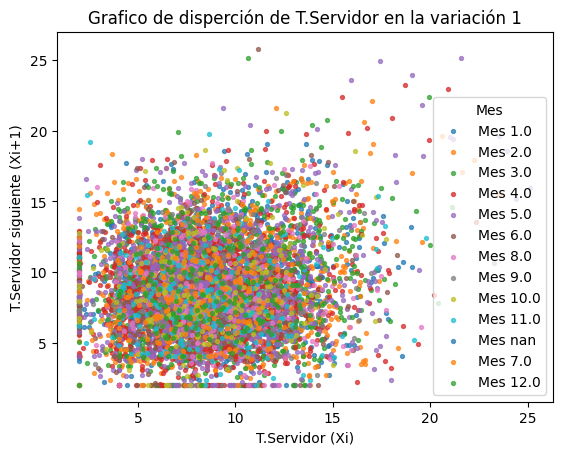

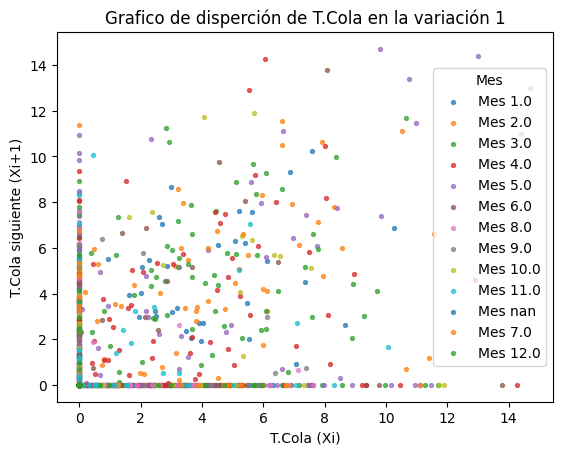

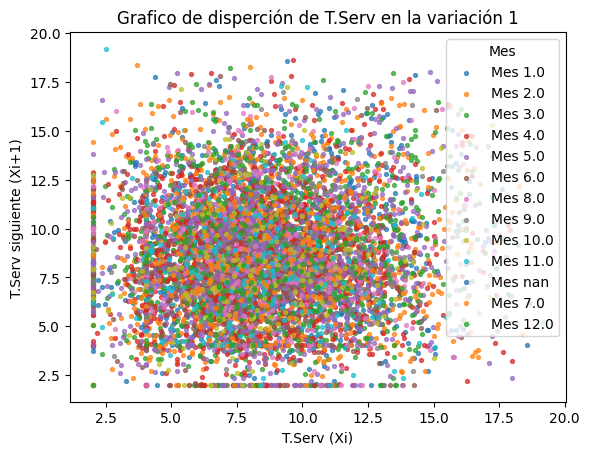

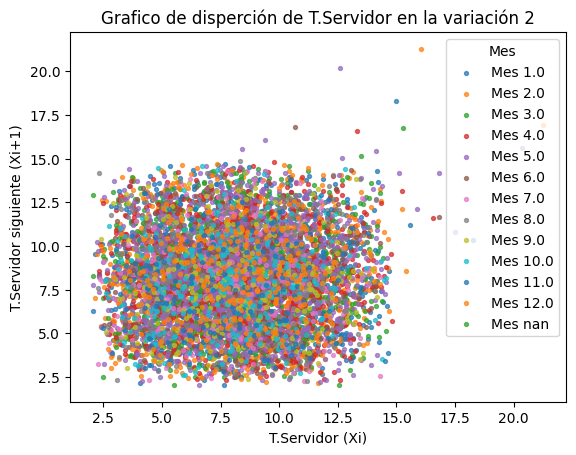

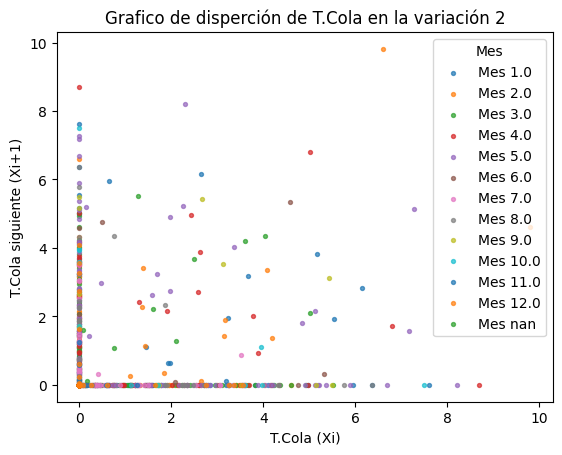

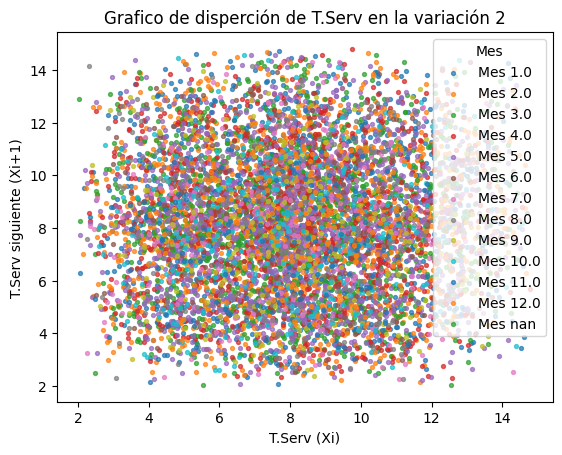

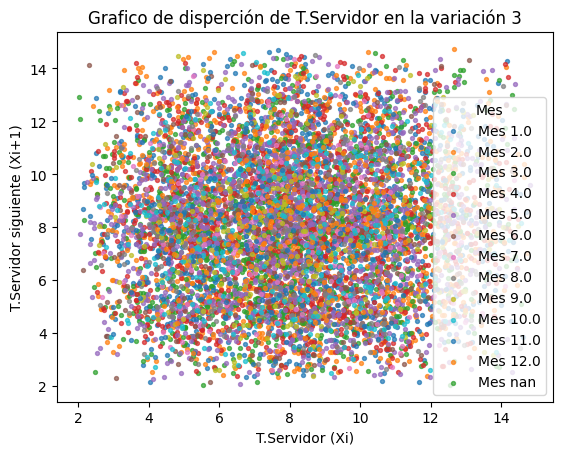

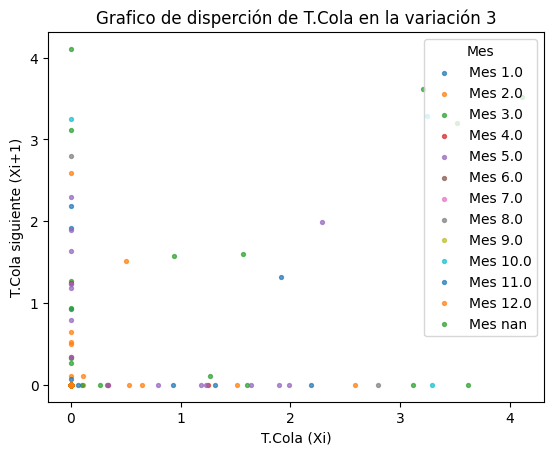

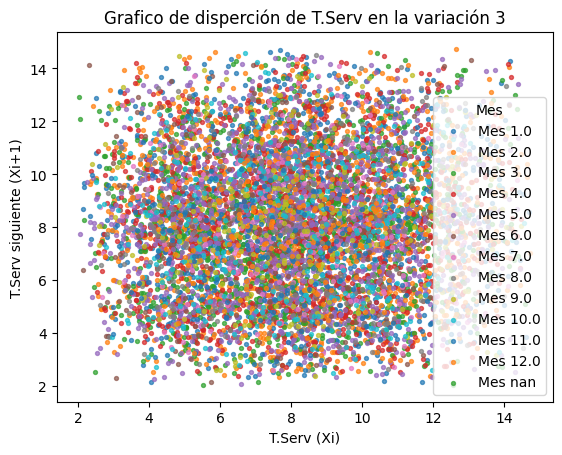

In [ ]:
for turno in [1]:
    for grupo in [1, 2, 3]:
        base, nombres = saca(turno, grupo)
        todo = lectura(nombres.sheet_names)
        for columna in ['T.Servidor','T.Cola','T.Serv']:
          graficas(turno,grupo,todo,columna)

In [ ]:
medias,muestra=[],[]
medias_mes,medias_cola,medias_serv,muestra_mes,varianza_mes,varianza_cola,varianza_serv,tamano_mes=[],[],[],[],[],[],[],[]
for turno in [1]:
    for grupo in [1, 2, 3]:
        base, nombres = saca(turno, grupo)
        todo = lectura(nombres.sheet_names)

        media_grupo, muestra_grupo, medias_mes_grupo,medias_mes_cola,medias_mes_serv, muestra_mes_grupo, varianza_mes_grupo, varianza_mes_cola, varianza_mes_serv, tamano_mes_grupo= procesar_grupo(turno, grupo, todo)

        medias.append(media_grupo)
        muestra.append(muestra_grupo)
        medias_mes.extend(medias_mes_grupo)
        medias_cola.extend(medias_mes_cola)
        medias_serv.extend(medias_mes_serv)
        varianza_mes.extend(varianza_mes_grupo)
        varianza_cola.extend(varianza_mes_cola)
        varianza_serv.extend(varianza_mes_serv)
        muestra_mes.extend(muestra_mes_grupo)
        tamano_mes.extend(tamano_mes_grupo)

In [ ]:
muestra_mes_filtrada = [(t[0], t[1], t[2]) for t in muestra_mes if not np.isnan(t[2])]

resumen = pd.DataFrame({
    'Muestra': [t[0] for t in muestra_mes_filtrada],
    'Largo': tamano_mes,
    'Variacion': [t[1] for t in muestra_mes_filtrada],
    'Mes': [t[2] for t in muestra_mes_filtrada],
    'sistema_media': medias_mes,
    'sistema_varianza': varianza_mes,
    'cola_media': medias_cola,
    'cola_varianza': varianza_cola,
    'servicio_media': medias_serv,
    'servicio_varianza': varianza_serv,
})


In [ ]:
resumen

,Muestra,Largo,Variacion,Mes,sistema_media,sistema_varianza,cola_media,cola_varianza,servicio_media,servicio_varianza
0,1,1342,1,1.0,8.781940,9.748632,0.207933,0.979697,8.573852,8.869307
1,1,1299,1,2.0,8.683885,11.190984,0.195596,0.957524,8.488289,9.941680
2,1,1299,1,3.0,8.909476,11.095739,0.355851,1.916713,8.553625,8.865528
3,1,1361,1,4.0,8.690998,10.865762,0.272823,1.490106,8.418175,8.880981
4,1,1369,1,5.0,8.936688,12.115788,0.267531,2.042736,8.669157,9.579605
5,1,313,1,6.0,8.661582,11.275281,0.368840,2.127757,8.292742,8.855109
6,1,279,1,8.0,9.165622,12.388280,0.566782,3.507425,8.598840,9.074615
7,1,359,1,9.0,9.046513,11.208507,0.175457,0.814382,8.871056,9.901834
8,1,236,1,10.0,8.849865,11.001787,0.211279,1.003677,8.638585,9.379035
9,1,261,1,11.0,8.893217,10.924747,0.406226,2.575127,8.486990,8.362446


In [ ]:
meses_dict = {'Abril': 4, 'Septiembre': 9,'Noviembre': 11}
real['num_mes'] = real['Mes'].map(meses_dict)

In [ ]:
for x in ['mean','var']:
  print("La "+x)
  print(pd.DataFrame(real.groupby(['num_mes']).agg({'T.Servidor': x,'T.Cola': x,'T.Atendido':x}).reset_index()))

La mean
   num_mes  T.Servidor    T.Cola  T.Atendido
0        4    9.013178  1.083438    7.929740
1        9    8.910839  1.079669    7.831170
2       11    9.029003  1.054211    7.974792
La var
   num_mes  T.Servidor    T.Cola  T.Atendido
0        4    9.754989  0.357936    8.917874
1        9    9.461555  0.372350    8.692490
2       11    9.052424  0.261880    8.407856


In [ ]:
data

,num_mes,T.Servidor,T.Cola,T.Atendido
0,4,9.013178,1.083438,7.929740
1,9,8.910839,1.079669,7.831170
2,11,9.029003,1.054211,7.974792


In [ ]:
data

,num_mes,T.Servidor,T.Cola,T.Atendido
0,4,9.754989,0.357936,8.917874
1,9,9.461555,0.372350,8.692490
2,11,9.052424,0.261880,8.407856


In [ ]:
limite_inf,limite_sup,mes,cosa=[],[],[],[]
for i in real['num_mes'].unique():
  for j in ['T.Servidor','T.Cola','T.Atendido']:
    var=real[(real['num_mes']==i)][j]
    n=len(var)
    m=var.mean()
    d=var.std()
    signi=0.99
    alfa=(1-signi)/2
    z=norm.ppf(alfa)
    error=np.abs(z*(d/np.sqrt(n)))
    limite_inf.append(m-error)
    limite_sup.append(m+error)
    mes.append(i)
    cosa.append(j)


In [ ]:
limites = pd.DataFrame({
    'Analisis': cosa,
    'Mes': mes,
    'limite_inf': limite_inf,
    'limite_sup': limite_sup,
})

In [ ]:
r4,r9,r11,r4c,r9c,r11c,r4s,r9s,r11s=[],[],[],[],[],[],[],[],[]
for i in resumen['Muestra'].unique():
  for m in limites['Mes'].unique():
    eval=limites[(limites['Mes']==m)]
    eval=eval.reset_index()
    for j in range(len(resumen['cola_media'])):
      w=-1
      for k in ['sistema','cola','servicio']:
        w=w+1
        lim_inf=eval['limite_inf'][w]
        lim_sup=eval['limite_sup'][w]
        if resumen[k+'_media'][j] < lim_inf or resumen[k+'_media'][j] > lim_sup:
          if w==0:
            if m==4:
              r4.append(False)
            elif m==9:
              r9.append(False)
            elif m==11:
              r11.append(False)
          elif w==1:
            if m==4:
              r4c.append(False)
            elif m==9:
              r9c.append(False)
            elif m==11:
              r11c.append(False)
          elif w==2:
            if m==4:
              r4s.append(False)
            elif m==9:
              r9s.append(False)
            elif m==11:
              r11s.append(False)
        else:
          if w==0:
            if m==4:
              r4.append(True)
            elif m==9:
              r9.append(True)
            elif m==11:
              r11.append(True)
          elif w==1:
            if m==4:
              r4c.append(True)
            elif m==9:
              r9c.append(True)
            elif m==11:
              r11c.append(True)
          elif w==2:
            if m==4:
              r4s.append(True)
            elif m==9:
              r9s.append(True)
            elif m==11:
              r11s.append(True)

In [ ]:
resumen['H0_server_4_servidor']=r4
resumen['H0_server_9_servidor']=r9
resumen['H0_server_11_servidor']=r11
resumen['H0_cola_4_servidor']=r4c
resumen['H0_cola_9_servidor']=r9c
resumen['H0_cola_11_servidor']=r11c
resumen['H0_servidor_4_servidor']=r4s
resumen['H0_servidor_9_servidor']=r9s
resumen['H0_servidor_11_servidor']=r11s

In [ ]:
resumen

,Muestra,Largo,Variacion,Mes,sistema_media,sistema_varianza,cola_media,cola_varianza,servicio_media,servicio_varianza,H0_server_4_servidor,H0_server_9_servidor,H0_server_11_servidor,H0_cola_4_servidor,H0_cola_9_servidor,H0_cola_11_servidor,H0_servidor_4_servidor,H0_servidor_9_servidor,H0_servidor_11_servidor
0,1,1342,1,1.0,8.781940,9.748632,0.207933,0.979697,8.573852,8.869307,False,True,False,False,False,False,False,False,False
1,1,1299,1,2.0,8.683885,11.190984,0.195596,0.957524,8.488289,9.941680,False,False,False,False,False,False,False,False,False
2,1,1299,1,3.0,8.909476,11.095739,0.355851,1.916713,8.553625,8.865528,True,True,True,False,False,False,False,False,False
3,1,1361,1,4.0,8.690998,10.865762,0.272823,1.490106,8.418175,8.880981,False,False,False,False,False,False,False,False,False
4,1,1369,1,5.0,8.936688,12.115788,0.267531,2.042736,8.669157,9.579605,True,True,True,False,False,False,False,False,False
5,1,313,1,6.0,8.661582,11.275281,0.368840,2.127757,8.292742,8.855109,False,False,False,False,False,False,False,False,False
6,1,279,1,8.0,9.165622,12.388280,0.566782,3.507425,8.598840,9.074615,False,False,True,False,False,False,False,False,False
7,1,359,1,9.0,9.046513,11.208507,0.175457,0.814382,8.871056,9.901834,True,True,True,False,False,False,False,False,False
8,1,236,1,10.0,8.849865,11.001787,0.211279,1.003677,8.638585,9.379035,False,True,False,False,False,False,False,False,False
9,1,261,1,11.0,8.893217,10.924747,0.406226,2.575127,8.486990,8.362446,True,True,True,False,False,False,False,False,False


In [ ]:
limites

,Analisis,Mes,limite_inf,limite_sup
0,T.Servidor,4,8.929267,9.097089
1,T.Cola,4,1.067364,1.099511
2,T.Atendido,4,7.849510,8.009970
3,T.Servidor,9,8.829955,8.991722
4,T.Cola,9,1.063623,1.095714
5,T.Atendido,9,7.753644,7.908697
6,T.Servidor,11,8.947122,9.110883
7,T.Cola,11,1.040285,1.068138
8,T.Atendido,11,7.895880,8.053703


In [ ]:
resumen.groupby(['Mes'])['H0_server_4_servidor','H0_server_9_servidor','H0_server_11_servidor'].count()

<ipython-input-167-9cf56e37f468>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  resumen.groupby(['Mes'])['H0_server_4_servidor','H0_server_9_servidor','H0_server_11_servidor'].count()


,H0_server_4_servidor,H0_server_9_servidor,H0_server_11_servidor
Mes,,,
1.0,3,3,3
2.0,3,3,3
3.0,3,3,3
4.0,3,3,3
5.0,3,3,3
6.0,3,3,3
7.0,3,3,3
8.0,3,3,3
9.0,3,3,3


In [ ]:
resumen.groupby(['Mes'])['H0_cola_4_servidor','H0_cola_9_servidor','H0_cola_11_servidor'].count()

<ipython-input-168-310553003bda>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  resumen.groupby(['Mes'])['H0_cola_4_servidor','H0_cola_9_servidor','H0_cola_11_servidor'].count()


,H0_cola_4_servidor,H0_cola_9_servidor,H0_cola_11_servidor
Mes,,,
1.0,3,3,3
2.0,3,3,3
3.0,3,3,3
4.0,3,3,3
5.0,3,3,3
6.0,3,3,3
7.0,3,3,3
8.0,3,3,3
9.0,3,3,3


In [ ]:
resumen.groupby(['Mes'])['H0_servidor_4_servidor','H0_servidor_9_servidor','H0_servidor_11_servidor'].count()

<ipython-input-169-c9582cdefe59>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  resumen.groupby(['Mes'])['H0_servidor_4_servidor','H0_servidor_9_servidor','H0_servidor_11_servidor'].count()


,H0_servidor_4_servidor,H0_servidor_9_servidor,H0_servidor_11_servidor
Mes,,,
1.0,3,3,3
2.0,3,3,3
3.0,3,3,3
4.0,3,3,3
5.0,3,3,3
6.0,3,3,3
7.0,3,3,3
8.0,3,3,3
9.0,3,3,3
